In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, random
from sklearn import decomposition

In [2]:
class Parameter:
    "mini-batch Gradient Descent parameters"

    def __init__(self, n_batch, eta, n_epochs):
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadBatch(filename):
    cifar = unpickle(filename)

    X = cifar[b'data'].T/255.0  # numpy array of size dxN    
    y = np.array(cifar[b'labels'])  # vector of lables of size 1xN
    Y = np.zeros((10,X.shape[1]))  # matrix of KxN
    Y[y,np.arange(len(y))] = 1

    return X,Y,y


def evaluateClassifier(X,W,b):
    s = np.dot(W,X) + b
    p = np.exp(s)/np.expand_dims(np.exp(s).sum(axis=0),axis=0)  # matrix of size KxN
    return p


def Hinge_loss(X,y,W,b):
    N = len(y)
    scores = np.dot(W,X) + b  # matrix of size KxN
    score_y = scores[y,np.arange(N)]  # vector of size 1xN
    loss = np.maximum(0, scores - score_y[np.newaxis,:] + 1)
    loss[y,np.arange(N)] = 0  # set 0 at score_y
    
    return loss

def computeCost(X,Y,y,W,b,lamb,loss_func='softmax'):
    if loss_func=='softmax':
        P = evaluateClassifier(X,W,b)
        J = np.sum(-np.log(np.diag(np.dot(Y.T,P))))/(X.shape[1]+0.0) + lamb*np.sum(W*W)
    if loss_func=='svm':
        loss = Hinge_loss(X,y,W,b)
        J = np.sum(loss)/(X.shape[1]+0.0) + 0.5*lamb*np.sum(W*W)
    return J


def computeAccuracy(X,y,W,b,loss_func='softmax'):
    if loss_func=='softmax':
        P = evaluateClassifier(X,W,b)
        y_pred = np.argmax(P, axis=0)
    if loss_func=='svm':
        scores = np.dot(W,X) + b
        y_pred = np.argmax(scores, axis=0)
        
    acc = np.sum(y==y_pred)/(len(y)+0.0)
    return acc

def computeGradients(X,Y,y,W,b,lamb,loss_func='softmax'):
    N = X.shape[1]
    if loss_func=='softmax':
        P = evaluateClassifier(X,W,b)
        g = P-Y
        lamb *= 2
        
    if loss_func=='svm':
        loss = Hinge_loss(X,y,W,b)
        g = np.zeros(loss.shape)
        g[loss > 0.0] = 1
        count = np.sum(g, axis=0)
        g[y,np.arange(N)] = -count
        
    grad_b = np.expand_dims(g.sum(axis=1),axis=1)/(N+0.0)
    grad_w = np.dot(g,X.T)/(N+0.0) + lamb*W               
    return grad_w, grad_b


# Compute analytic gradient
def computeGradsNumSlow(X, Y, y, W, b, lamb, h=1e-6, loss_func='softmax'):
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))

    for i in range(len(b)):
        b[i] -= h
        c1 = computeCost(X, Y, y, W, b, lamb, loss_func)
        b[i] += 2*h
        c2 = computeCost(X, Y, y, W, b, lamb, loss_func)
        b[i] -= h
        grad_b[i] = (c2-c1)/(2*h)

    for i in range(no):
        for j in range(d):
            W[i,j] -= h
            c1 = computeCost(X, Y, y, W, b, lamb, loss_func)
            W[i,j] += 2*h
            c2 = computeCost(X, Y, y, W, b, lamb, loss_func)
            W[i,j] -= h
    
            grad_W[i,j] = (c2-c1)/(2*h)
        
    return grad_W, grad_b


def generateBatches(X,Y,y,n_batch):
    d,N = X.shape
    K = Y.shape[0]
    XBatch = np.zeros((d,n_batch,int(N/n_batch)))
    YBatch = np.zeros((K,n_batch,int(N/n_batch)))
    yBatch = np.zeros((n_batch,int(N/n_batch)))
    
    for i in range(int(N/n_batch)):
        i_start = i*n_batch
        i_end = (i+1)*n_batch
        XBatch[:,:,i] = X[:,i_start:i_end]
        YBatch[:,:,i] = Y[:,i_start:i_end]
        yBatch[:,i] = y[i_start:i_end]
    YBatch = YBatch.astype(int)  # convert to int in case the type is changed
    yBatch = yBatch.astype(int)
    return XBatch, YBatch, yBatch

def plotResults(x,y,name='loss',par='0'):
    fig = plt.figure()
    plt.plot(x,y[0],label='training '+name)
    plt.plot(x,y[1],label='validation '+name)
    plt.legend(loc=0)
    plt.xlabel('n_epochs')
    plt.ylabel(name)
    fig.savefig('Figures/'+name+'_params'+par+'.pdf')
    plt.show()


# Check gradient computation    
def checkGrads(X, Y, y, W, b, lamb, h=1e-6, loss_func='softmax'):
    eps = 1e-30
    error = 1e-6
    
    gW1,gb1 = computeGradsNumSlow(X, Y, y, W, b, lamb, h, loss_func)
    gW2,gb2 = computeGradients(X,Y,y,W,b,lamb,loss_func)
    print(gW1,gb1)
    print(gW2,gb2)
    
    error_w = np.abs(gW1-gW2)/np.maximum(eps,np.abs(gW1)+np.abs(gW2))
    error_b = np.abs(gb1-gb2)/np.maximum(eps,np.abs(gb1)+np.abs(gb2))
    print('The number of error (relative error > 1e-6) of W:', np.sum(error_w>error))
    print('The maximum of relative error of W:', np.max(error_w))
    print('The number of error (relative error > 1e-6) of b:', np.sum(error_b>error))
    print('The maximum of relative error of b:', np.max(error_b))


# Plot W
def plotW(W,class_name,arg_par='0'):
    fig=plt.figure(figsize=(20,2))
    for i in range(10):
        im = W[i,:].reshape(3,32,32)
        img = np.transpose((im-np.min(im))/(np.max(im)-np.min(im)),(1,2,0))
        plt.subplot(1, 10, i+1)                 
        plt.title(class_name[i])
        plt.imshow(img)
        plt.axis('off')
                       
    plt.savefig('Figures/imW_params'+arg_par+'.pdf')
    plt.show()
    

In [3]:
def miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,loss_func='softmax',eta_factor=1,arg_par='0',shuf=False,stop=False,plot=True):
    X_train = X[0]
    Y_train = Y[0]
    y_train = y[0]
    X_val = X[1]
    Y_val = Y[1]
    y_val = y[1]
    
    d,N = X_train.shape
    numBatches = int(N/GDparams.n_batch)
    
    # randomly initialize the weights and the thresholds
    W_star = W
    b_star = b
    
    if stop:
        acc_err = 0.0
        acc_val_pre = 0.0
    if plot:
        loss_train = np.zeros(GDparams.n_epochs)   
        loss_val = np.zeros(GDparams.n_epochs)
        error_train = np.zeros(GDparams.n_epochs)   
        error_val = np.zeros(GDparams.n_epochs) 
    if not shuf:
        XBatch,YBatch,yBatch = generateBatches(X_train,Y_train,y_train,GDparams.n_batch)
    
    for i in range(GDparams.n_epochs):
        # An improvements using shuffle to reorder training data
        if shuf:
            permute = list(range(N))
            random.shuffle(permute)
            X_train = X_train[:,permute]
            Y_train = Y_train[:,permute]
            y_train = y_train[permute]
            XBatch,YBatch,yBatch = generateBatches(X_train,Y_train,y_train,GDparams.n_batch)

        for j in range(numBatches):
            xTr = XBatch[:,:,j]
            yTr = YBatch[:,:,j]
            labelTr = yBatch[:,j]
            grad_w,grad_b = computeGradients(xTr,yTr,labelTr,W_star,b_star,lamb,loss_func)
            # update the weights and the thresholds
            W_star = W_star - GDparams.eta*grad_w
            b_star = b_star - GDparams.eta*grad_b
           
        GDparams.eta *= eta_factor # decay learning rate a factor 0.9
        
        if stop and i%5==0:
            acc_val = computeAccuracy(X_val,y_val,W_star,b_star,loss_func)
            if acc_val-acc_val_pre<acc_err and acc_val>0.3:
                print('Stop at epoch',i)
                break
            acc_val_pre = acc_val
            
        if plot:
            loss_train[i] = computeCost(X_train,Y_train,y_train,W_star,b_star,lamb,loss_func)        
            loss_val[i] = computeCost(X_val,Y_val,y_val,W_star,b_star,lamb,loss_func)
        
            error_train[i] = 1-computeAccuracy(X_train,y_train,W_star,b_star,loss_func)
            error_val[i] = 1-computeAccuracy(X_val,y_val,W_star,b_star,loss_func)
    if stop:
        GDparams.n_epochs = i
        loss_train = loss_train[:i]
        loss_val = loss_val[:i]
        error_train = error_train[:i]
        error_val = error_val[:i]
        
    if plot:
        plotResults(range(GDparams.n_epochs),[loss_train, loss_val],'loss',arg_par)
        plotResults(range(GDparams.n_epochs),[error_train, error_val],'error',arg_par)
    
    return W_star,b_star

In [4]:
# (a) Load data
XTr_1,YTr_1,yTr_1 = loadBatch('cifar-10-batches-py/data_batch_1')  # Training set
XTr_2,YTr_2,yTr_2 = loadBatch('cifar-10-batches-py/data_batch_2') 
XTr_3,YTr_3,yTr_3 = loadBatch('cifar-10-batches-py/data_batch_3')
XTr_4,YTr_4,yTr_4 = loadBatch('cifar-10-batches-py/data_batch_4')
XTr_5,YTr_5,yTr_5 = loadBatch('cifar-10-batches-py/data_batch_5')
XTr = np.concatenate((XTr_1, XTr_2, XTr_3, XTr_4, XTr_5), axis=1)
YTr = np.concatenate((YTr_1, YTr_2, YTr_3, YTr_4, YTr_5), axis=1)
yTr = np.concatenate((yTr_1, yTr_2, yTr_3, yTr_4, yTr_5))

XVa = XTr[:,-1000:] 
YVa = YTr[:,-1000:]
yVa = yTr[-1000:]
XTr = XTr[:,:-1000] 
YTr = YTr[:,:-1000]
yTr = yTr[:-1000]

XTe,YTe,yTe = loadBatch('cifar-10-batches-py/test_batch')    # Test set
names = unpickle("cifar-10-batches-py/batches.meta")[b'label_names']  # list if size (10,1)

K = len(names)
class_name = []
for i in range(K):
    class_name.append(names[i].decode("utf-8"))

In [51]:
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

d = XTr.shape[0]
#Initialize the parameters W and b
W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01

In [27]:
# (a) - parameter setting 2
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '(a)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

KeyboardInterrupt: 

In [ ]:
# (a) - parameter setting 3
lamb = 0.1
GDparams = Parameter(100,0.01,40)
name_par = '(a)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

In [5]:
# (b)
X = [XTr_1, XTr_2]
Y = [YTr_1, YTr_2]
y = [yTr_1, yTr_2]
d = XTr.shape[0]
#Initialize the parameters W and b
W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01

Stop at epoch 100


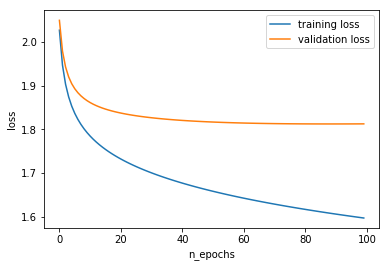

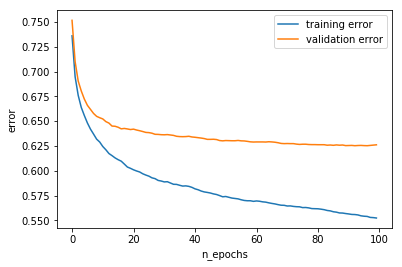

Execution time:  241.51974511146545
The accuracy on test set:  37.04 %


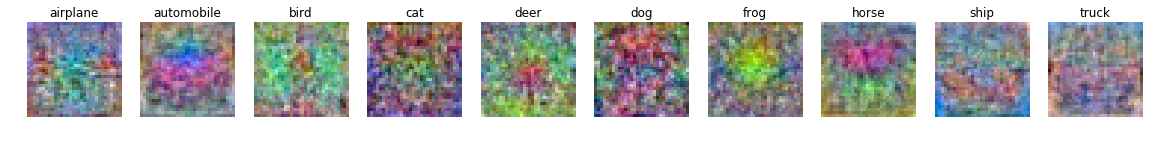

In [6]:
# (b)
lamb = 0
GDparams = Parameter(100,0.01,200)
name_par = '(b)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

Stop at epoch 50


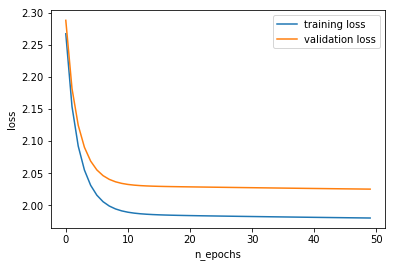

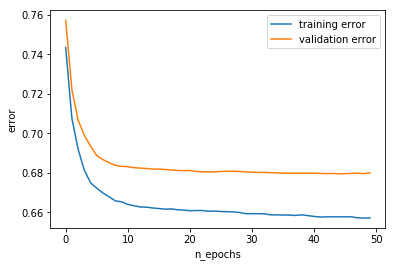

Execution time:  126.2293770313263
The accuracy on test set:  33.4 %


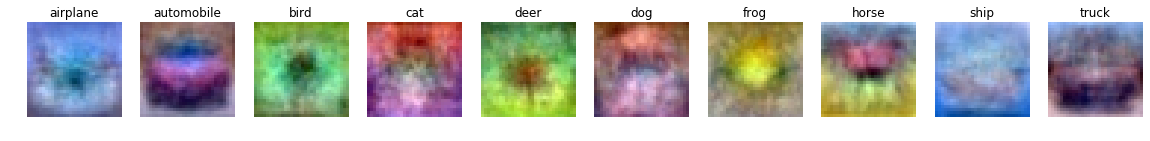

In [7]:
# (b)
lamb = 0.1
GDparams = Parameter(100,0.01,200)
name_par = '(b)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

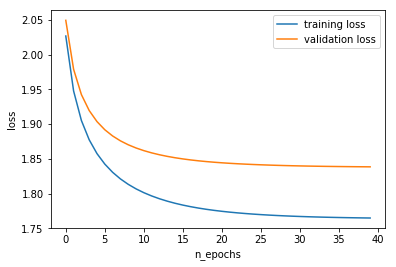

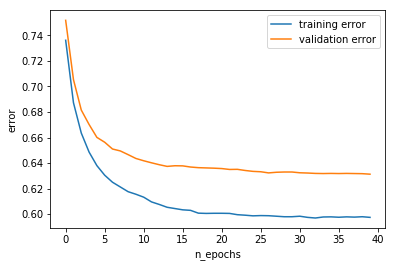

Execution time:  98.59087419509888
The accuracy on test set:  37.6 %


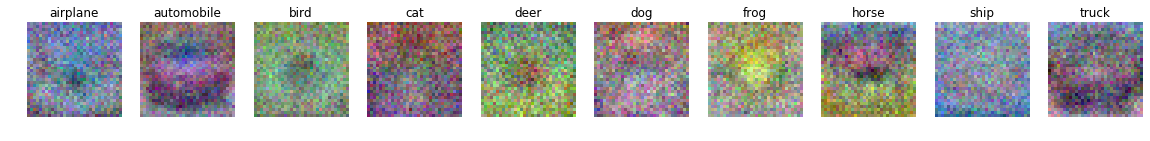

In [8]:
# (d) - This parameter setting show a high learning rate -> decrease to improve
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '(d)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

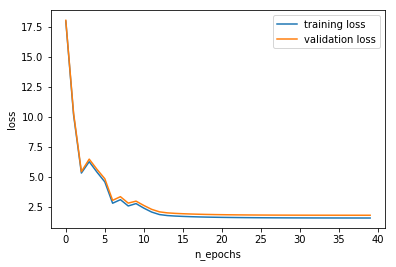

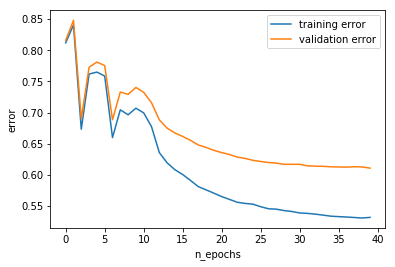

Execution time:  109.44035029411316
The accuracy on test set:  38.690000000000005 %


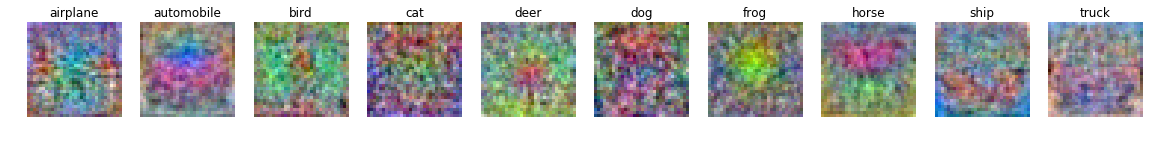

In [12]:
# (d)
lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '(d)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

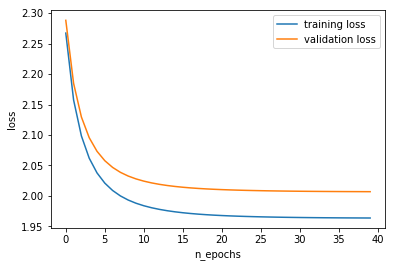

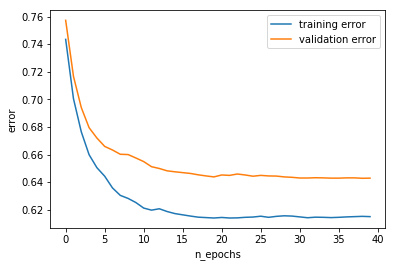

Execution time:  99.8812518119812
The accuracy on test set:  36.480000000000004 %


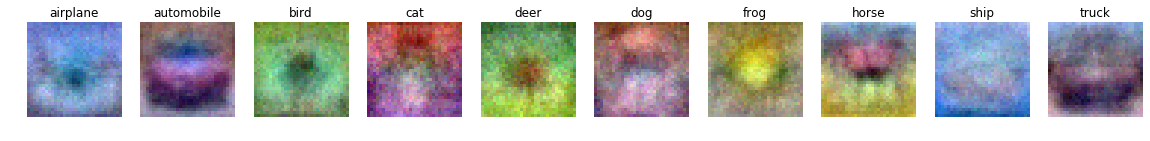

In [9]:
# (d)
lamb = 0.1
GDparams = Parameter(100,0.01,40)
name_par = '(d)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

Stop at epoch 55


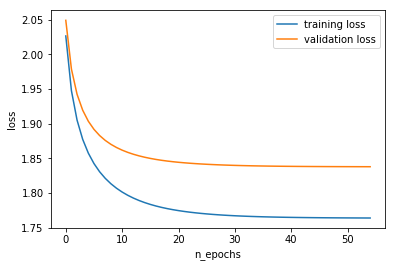

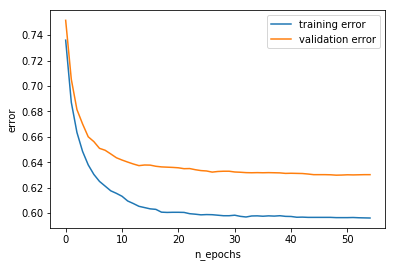

Execution time:  145.7982680797577
The accuracy on test set:  37.580000000000005 %


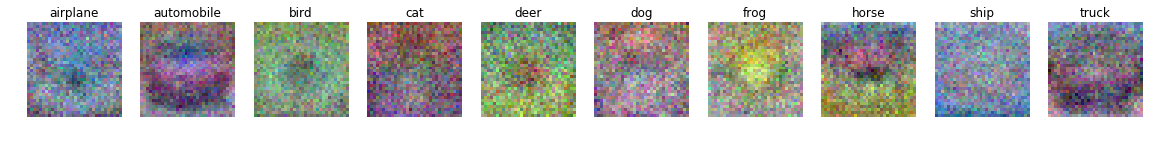

In [10]:
# (d) + (b)
lamb = 0
GDparams = Parameter(100,0.01,200)
name_par = '(bd)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

Stop at epoch 40


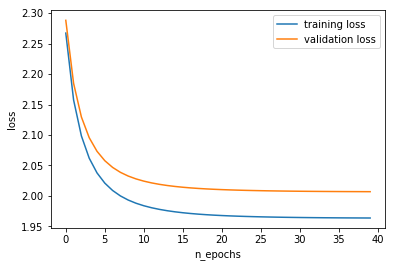

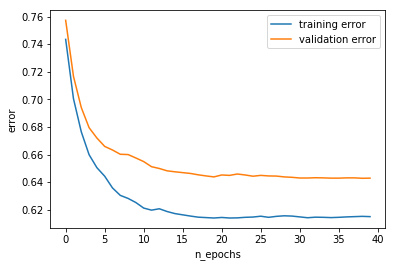

Execution time:  97.14501190185547
The accuracy on test set:  36.47 %


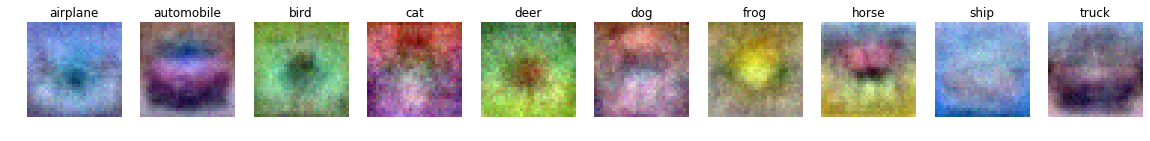

In [11]:
# (d) + (b)
lamb = 0.1
GDparams = Parameter(100,0.01,200)
name_par = '(bd)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

In [13]:
# (e) Xavier initialization
sigma = 1/np.sqrt(d)
W = W*sigma/0.01
b = b*sigma/0.01

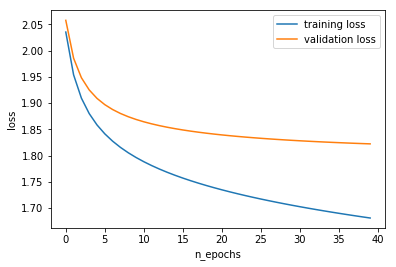

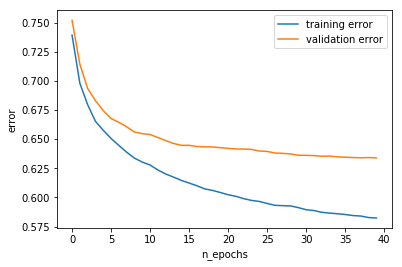

Execution time:  109.63599896430969
The accuracy on test set:  36.65 %


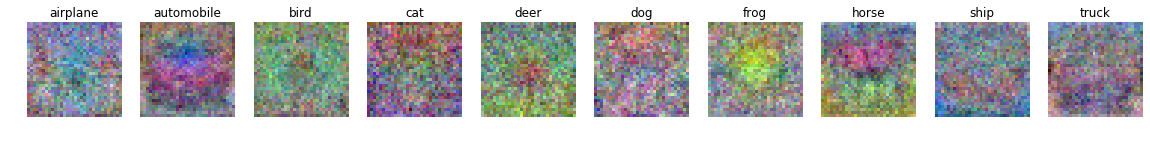

In [14]:
# (e) -> look improved
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '(e)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

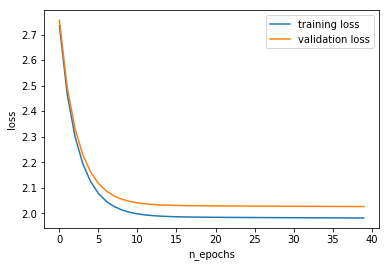

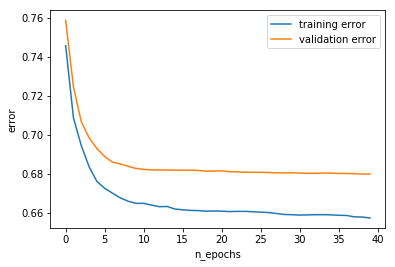

Execution time:  105.33529710769653
The accuracy on test set:  33.300000000000004 %


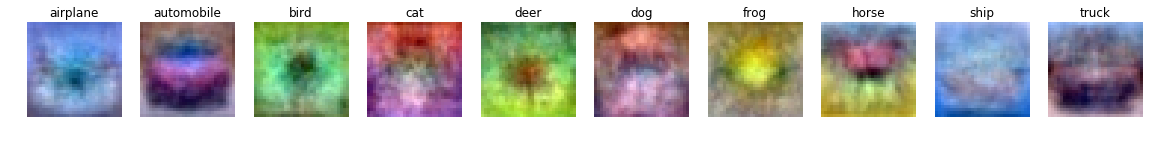

In [15]:
# (e)
lamb = 0.1
GDparams = Parameter(100,0.01,40)
name_par = '(e)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

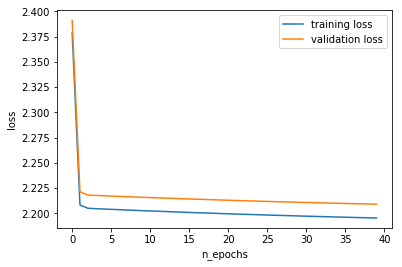

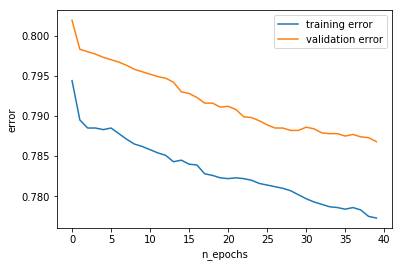

Execution time:  103.34466791152954
The accuracy on test set:  21.9 %


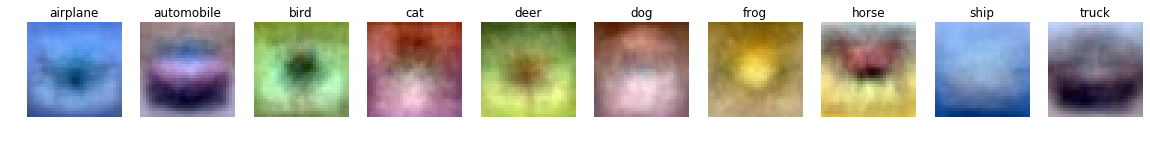

In [20]:
# (e)
lamb = 1
GDparams = Parameter(100,0.01,40)
name_par = '(e)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

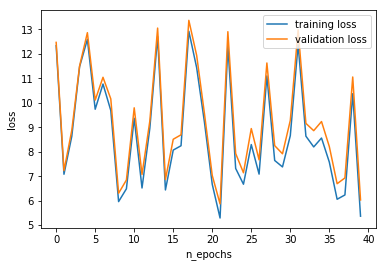

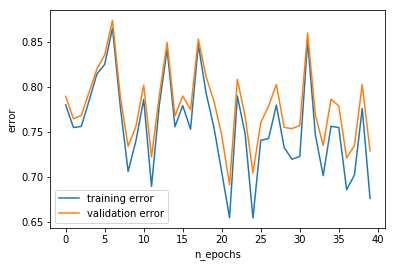

Execution time:  98.74072694778442
The accuracy on test set:  27.57 %


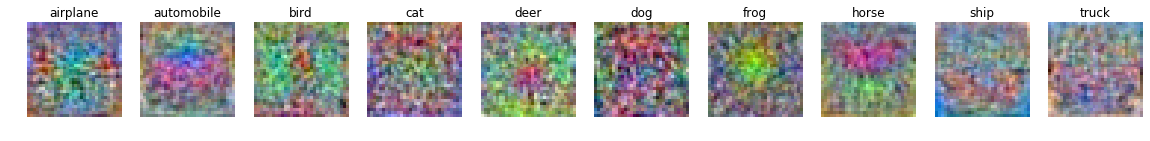

In [16]:
# (e)
lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '(e)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

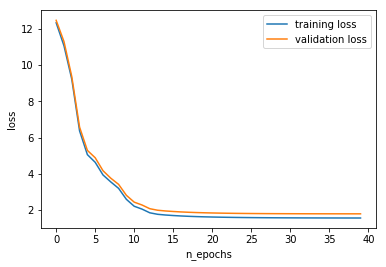

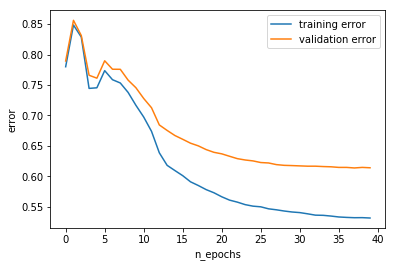

Execution time:  103.5338077545166
The accuracy on test set:  38.5 %


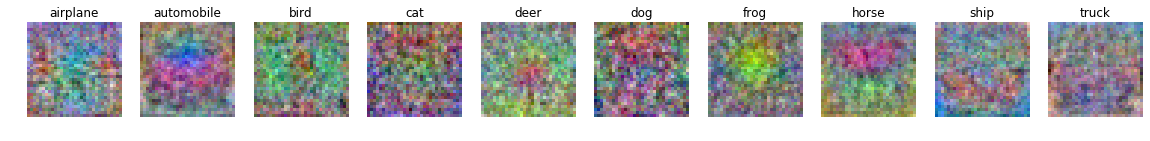

In [17]:
# (d) + (e)
lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '(de)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

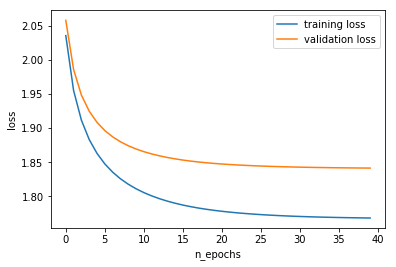

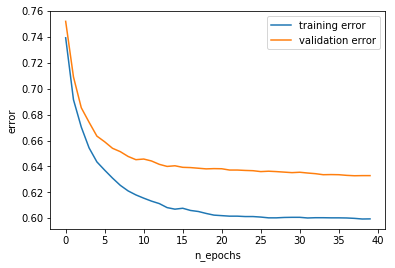

Execution time:  112.17360091209412
The accuracy on test set:  37.21 %


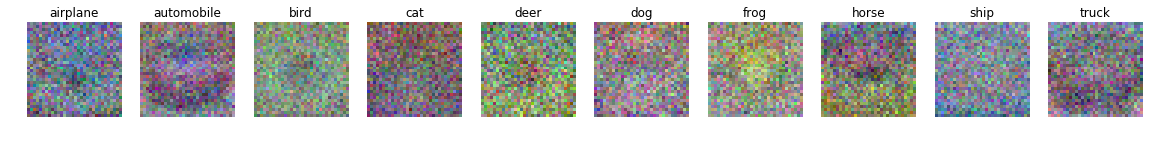

In [18]:
# (d) + (e)
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '(de)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

Stop at epoch 55


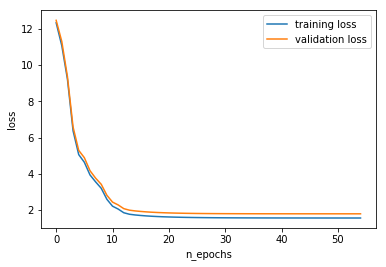

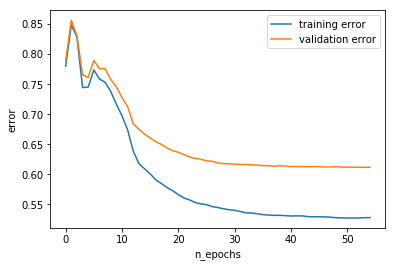

Execution time:  138.5592999458313
The accuracy on test set:  38.58 %


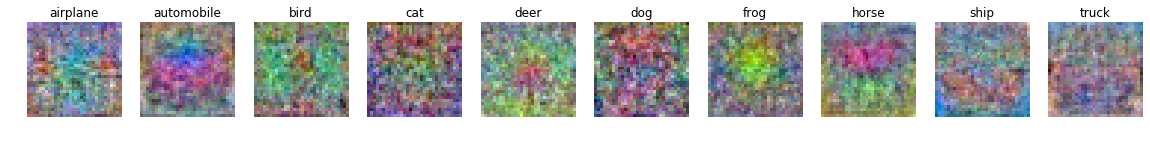

In [19]:
# (b) + (d) + (e)
lamb = 0
GDparams = Parameter(100,0.1,200)
name_par = '(bde)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

Stop at epoch 50


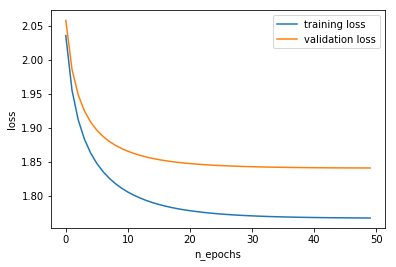

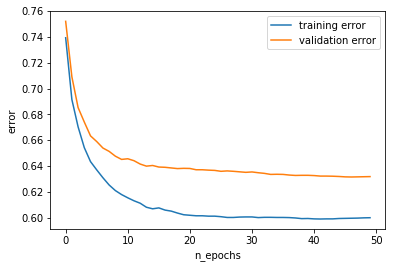

Execution time:  126.43721389770508
The accuracy on test set:  37.14 %


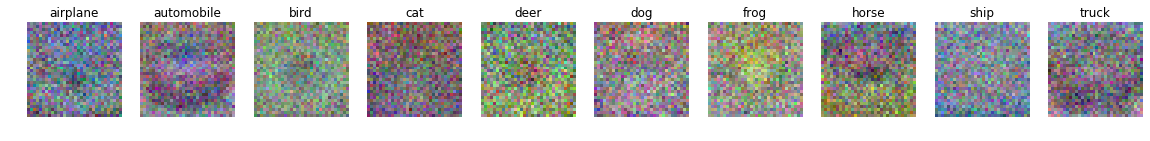

In [20]:
# (b) + (d) + (e)
lamb = 0
GDparams = Parameter(100,0.01,200)
name_par = '(bde)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

Stop at epoch 25


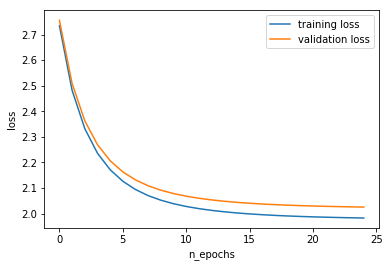

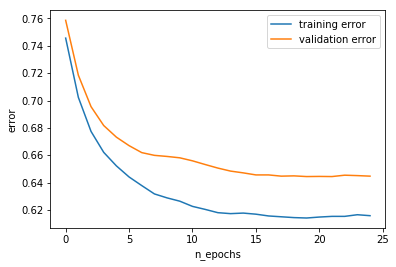

Execution time:  70.41208291053772
The accuracy on test set:  36.34 %


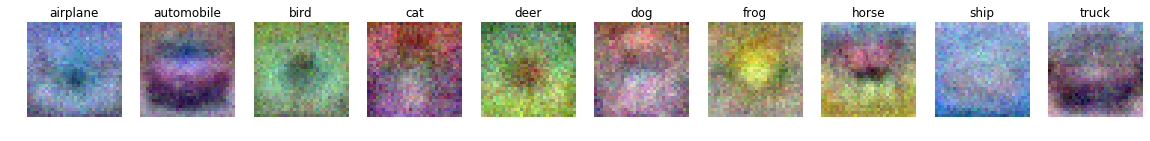

In [21]:
# (b) + (d) + (e)
lamb = 0.1
GDparams = Parameter(100,0.01,200)
name_par = '(bde)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,stop=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

In [22]:
# normal initialization
W = W*0.01/sigma
b = b*0.01/sigma

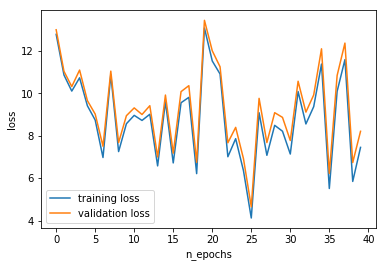

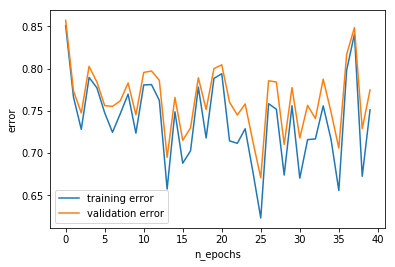

Execution time:  135.77074718475342
The accuracy on test set:  22.74 %


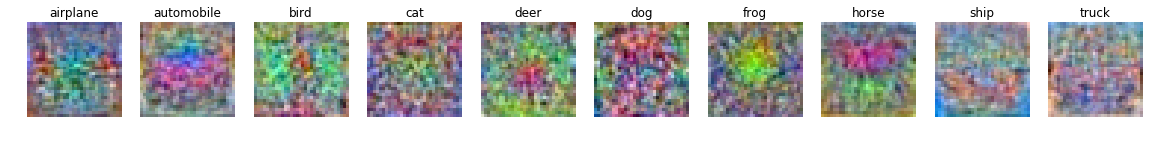

In [23]:
# (g) -> the accuracy is not smooth -> try to decay eta
lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '(g)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

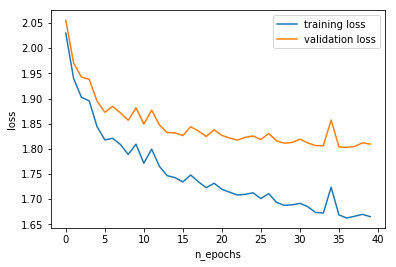

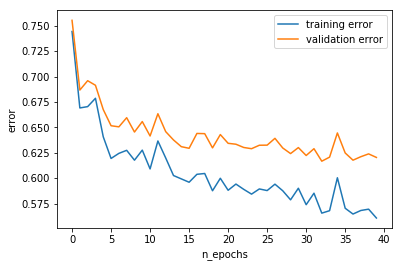

Execution time:  132.04262495040894
The accuracy on test set:  38.22 %


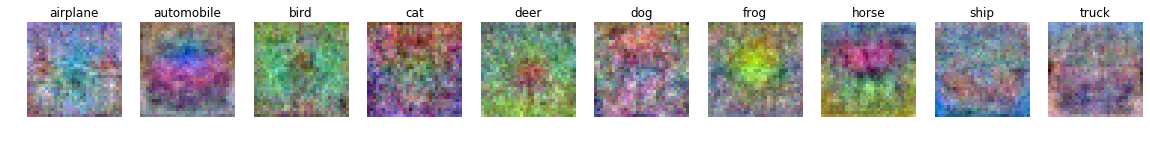

In [24]:
# (g)
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '(g)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

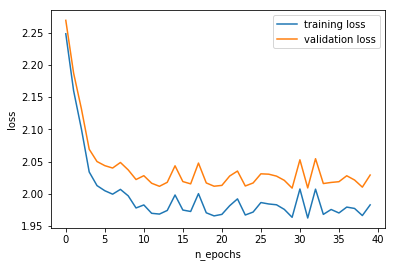

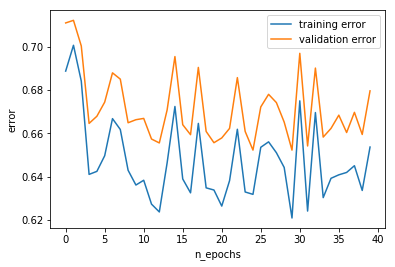

Execution time:  149.8328239917755
The accuracy on test set:  32.79 %


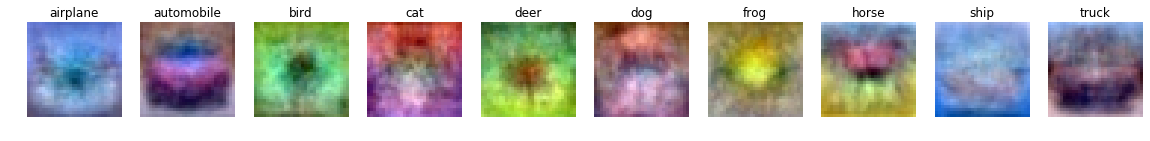

In [25]:
# (g)
lamb = 0.1
GDparams = Parameter(100,0.01,40)
name_par = '(g)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

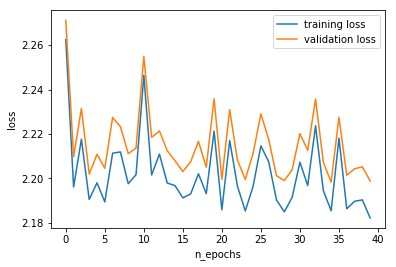

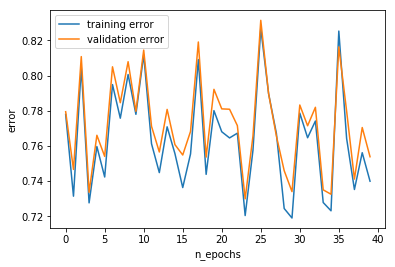

Execution time:  128.67484164237976
The accuracy on test set:  25.97 %


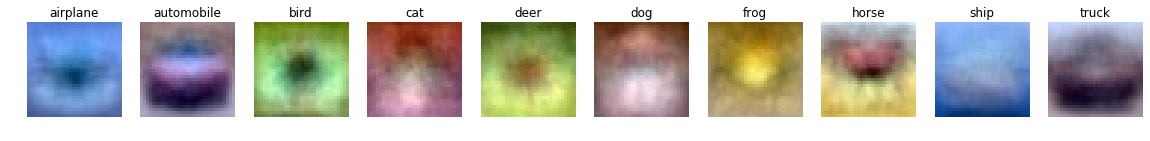

In [26]:
# (g)
lamb = 1
GDparams = Parameter(100,0.01,40)
name_par = '(g)3'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

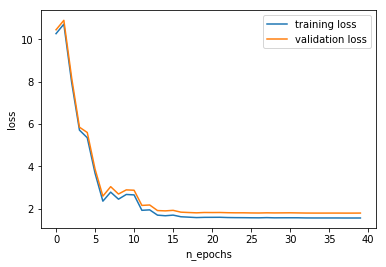

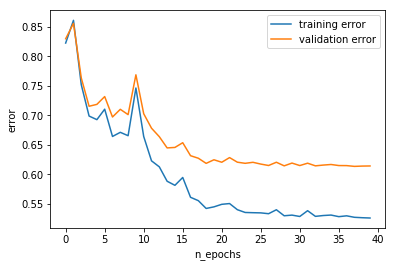

Execution time:  127.78584504127502
The accuracy on test set:  38.53 %


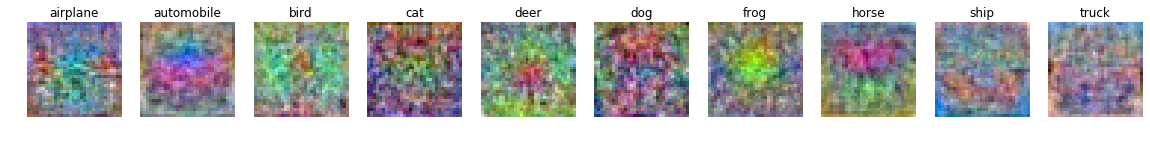

In [27]:
# (g) + (d)
lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '(dg)0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

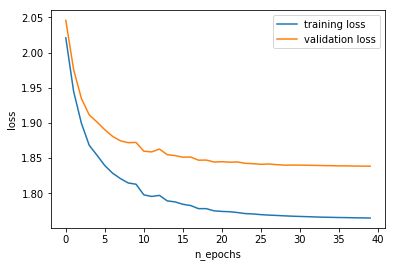

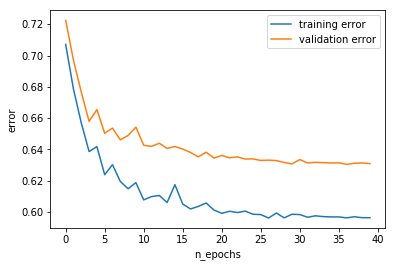

Execution time:  136.99655508995056
The accuracy on test set:  37.519999999999996 %


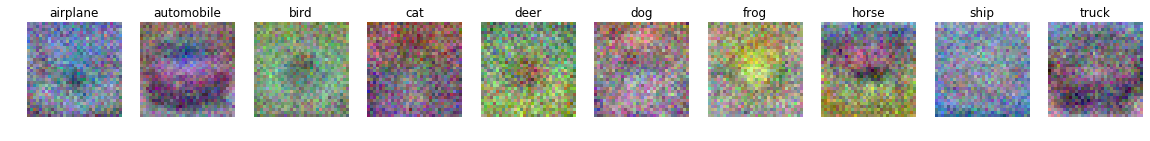

In [28]:
# (g) + (d)
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '(dg)1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

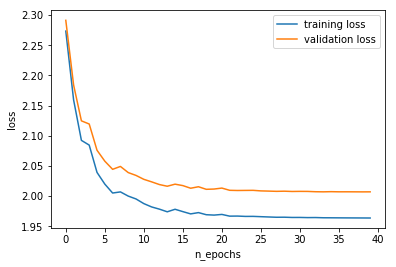

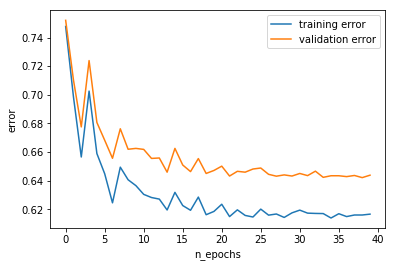

Execution time:  139.50075697898865
The accuracy on test set:  36.39 %


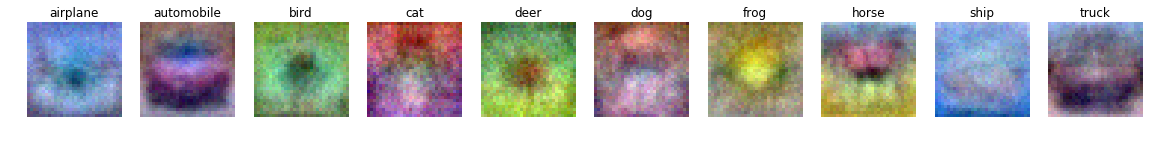

In [29]:
# (g) + (d)
lamb = 0.1
GDparams = Parameter(100,0.01,40)
name_par = '(dg)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

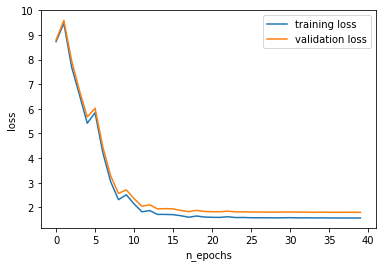

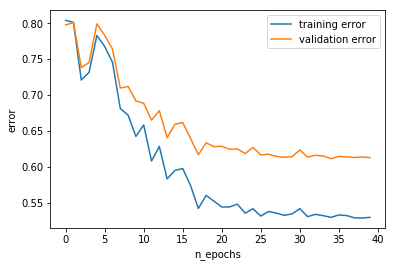

Execution time:  121.9149169921875
The accuracy on test set:  38.43 %


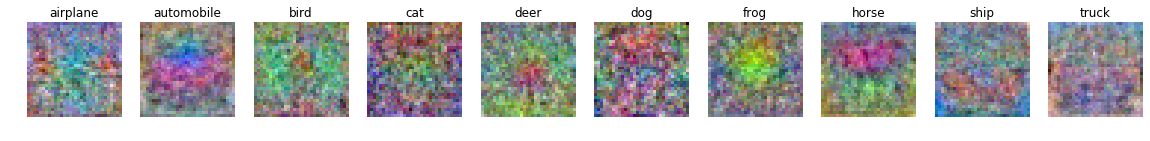

In [30]:
# (d) + (e) + (g)
W = W*sigma/0.01
b = b*sigma/0.01

lamb = 0
GDparams = Parameter(100,0.1,40)
name_par = '(deg)2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor=0.9,arg_par=name_par,shuf=True)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

In [20]:
# SVM
# Check gradient computation
lamb = 0
X = XTr[:20,:20]
Y = YTr[:20,:20]
y = yTr[:20]

d = X.shape[0]

W = np.random.randn(K,d) * 0.1
b = np.random.randn(K,1) * 0.1

#print(computeCost_svm(X,y,W,b,lamb))
#print(Hinge_loss(X,y,W,b))

checkGrads(X, Y, y, W, b, lamb, loss_func='svm')

The number of error (relative error > 1e-6) of W: 0
The maximum of relative error of W: 1.984380275219584e-07
The number of error (relative error > 1e-6) of b: 3
The maximum of relative error of b: 1.0


In [31]:
# Compare softmax+loss-entropy (smle) and Hinge loss (svm)
W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01

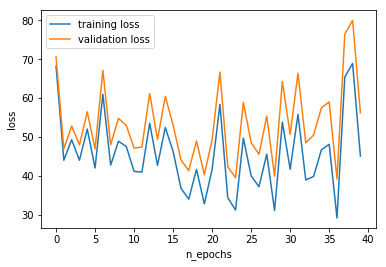

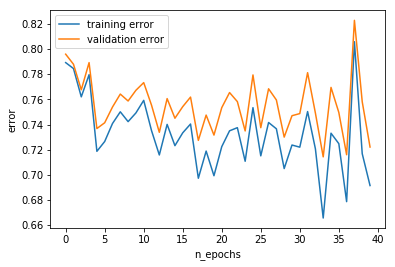

Execution time:  46.34813094139099
The accuracy on test set:  27.52 %


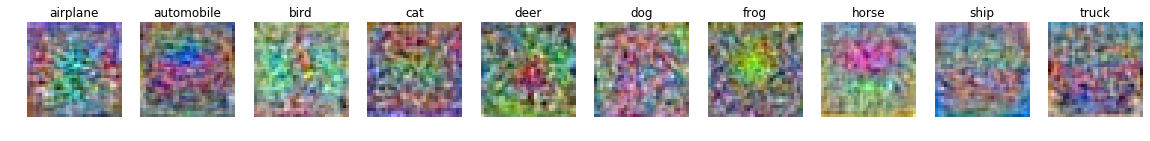

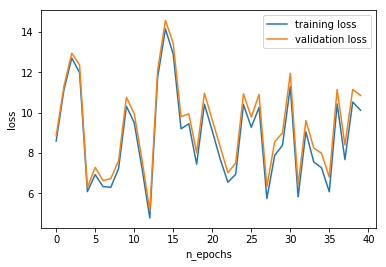

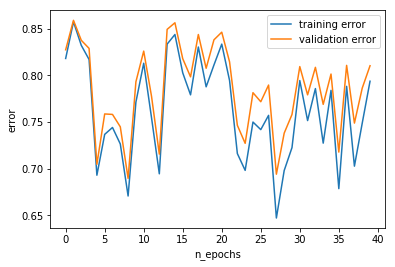

Execution time:  103.57990884780884
The accuracy on test set:  18.990000000000002 %


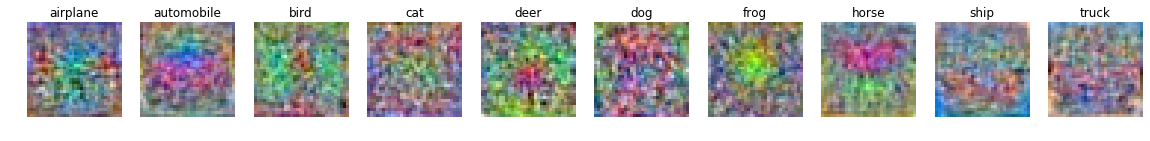

In [32]:
# Compare
lamb = 0
GDparams = Parameter(100,0.1,40)

# svm
name_par = 'svm-0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-0'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

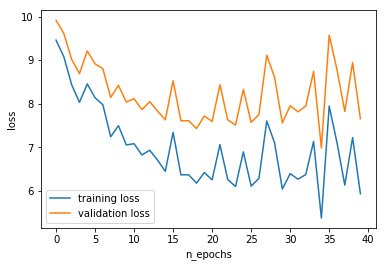

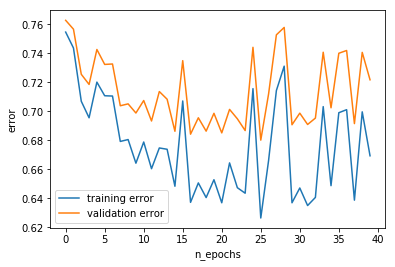

Execution time:  47.967122077941895
The accuracy on test set:  28.24 %


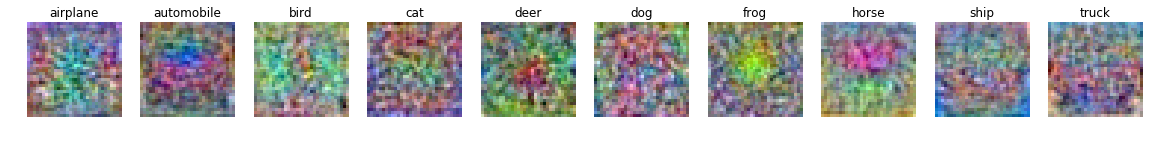

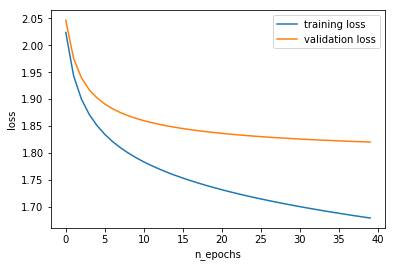

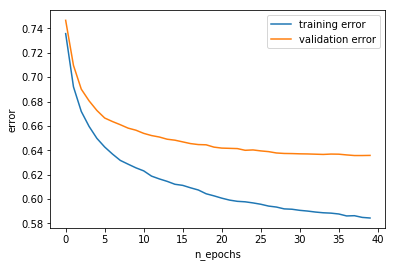

Execution time:  103.48178100585938
The accuracy on test set:  36.89 %


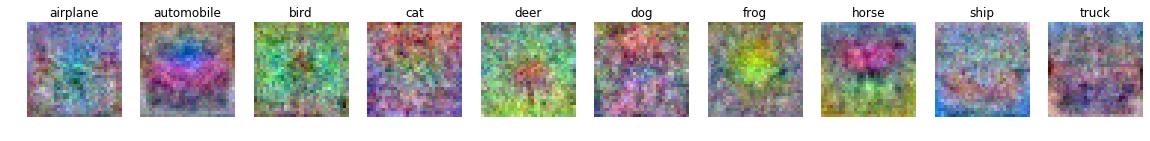

In [33]:
# Compare
lamb = 0
GDparams = Parameter(100,0.01,40)

# svm
name_par = 'svm-1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-1'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

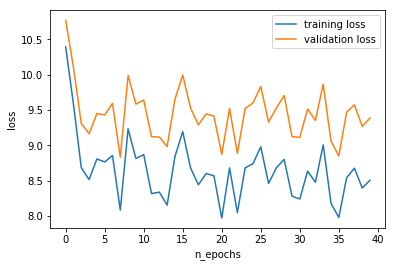

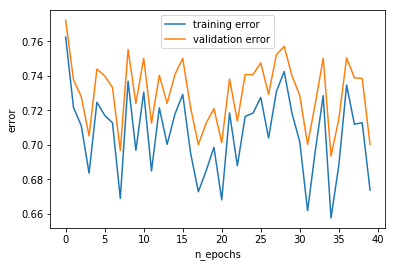

Execution time:  46.42212510108948
The accuracy on test set:  29.92 %


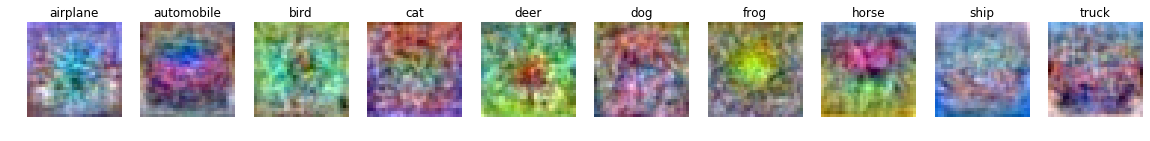

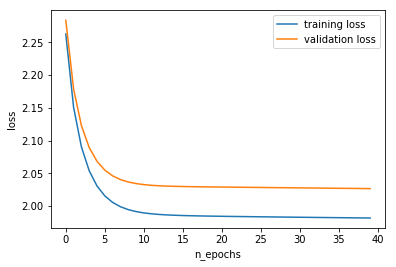

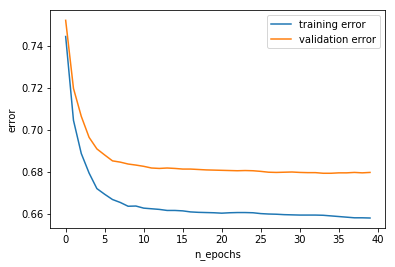

Execution time:  103.3327751159668
The accuracy on test set:  33.379999999999995 %


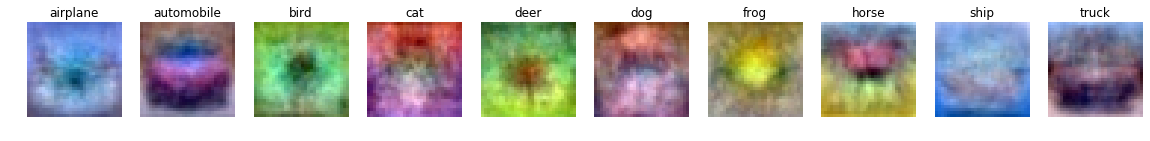

In [34]:
# Compare
lamb = 0.1
GDparams = Parameter(100,0.01,40)
# svm
name_par = 'svm-2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-2'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

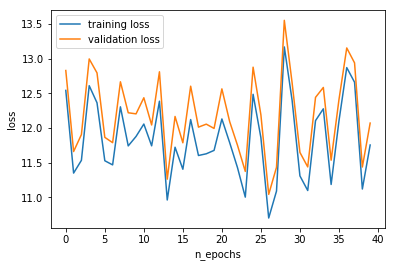

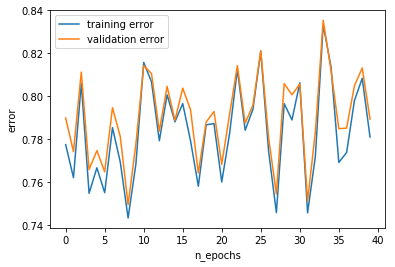

Execution time:  46.26965403556824
The accuracy on test set:  21.310000000000002 %


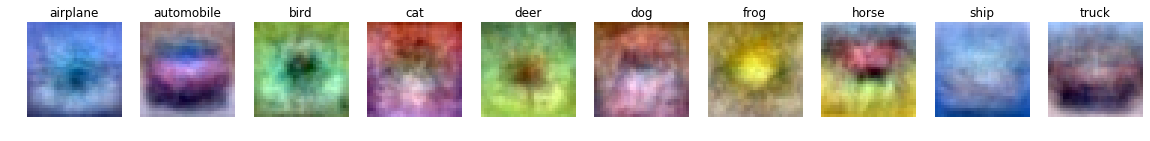

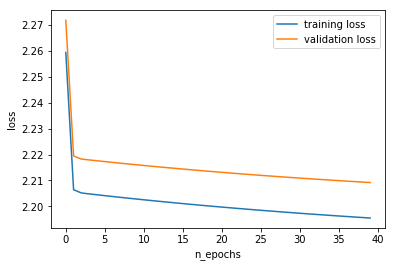

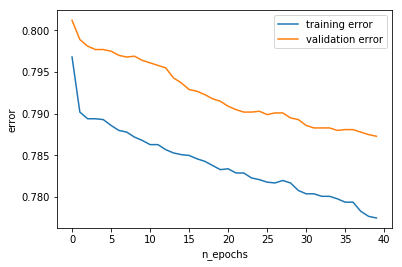

Execution time:  98.75230813026428
The accuracy on test set:  21.9 %


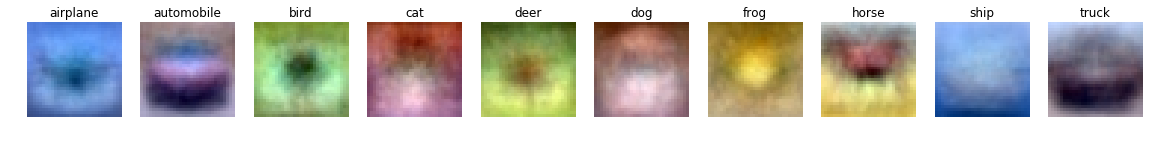

In [35]:
# Compare
lamb = 1
GDparams = Parameter(100,0.01,40)
# svm
name_par = 'svm-3'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-3'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

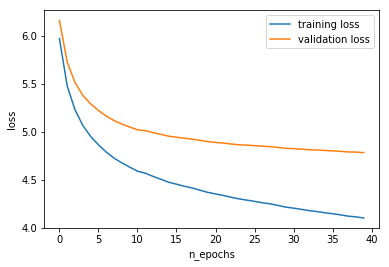

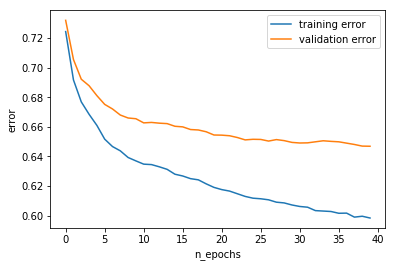

Execution time:  50.79869484901428
The accuracy on test set:  35.83 %


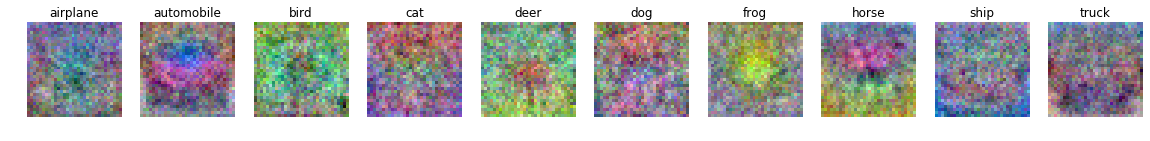

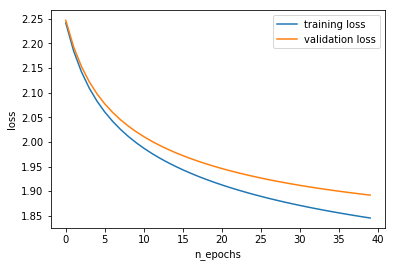

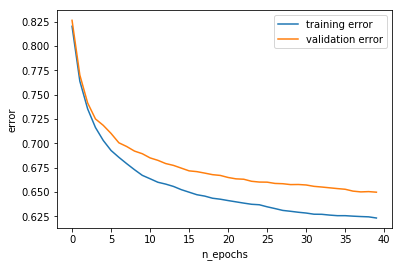

Execution time:  101.96408200263977
The accuracy on test set:  35.88 %


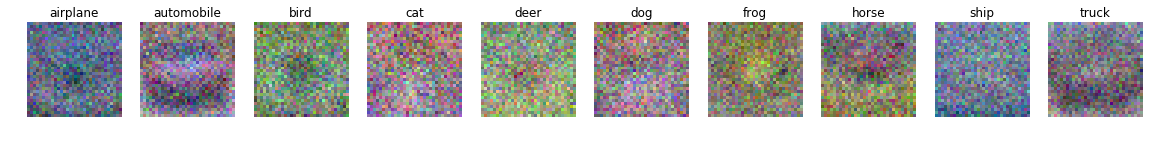

In [38]:
# Compare
lamb = 0
GDparams = Parameter(100,0.001,40)
# svm
name_par = 'svm-4'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-4'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

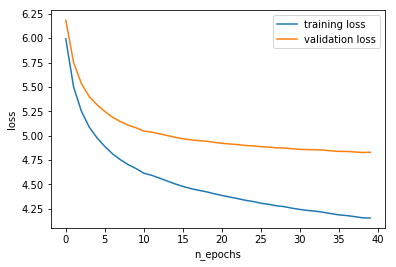

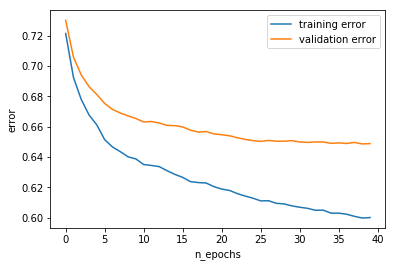

Execution time:  51.17157697677612
The accuracy on test set:  35.709999999999994 %


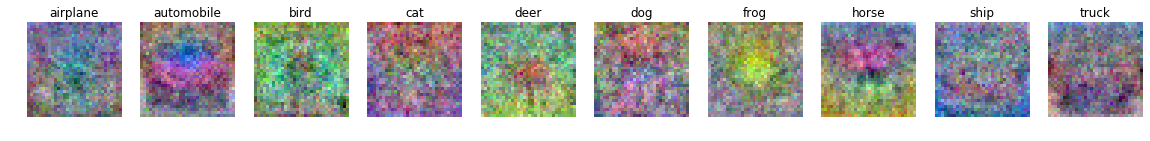

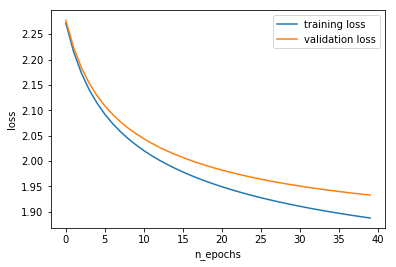

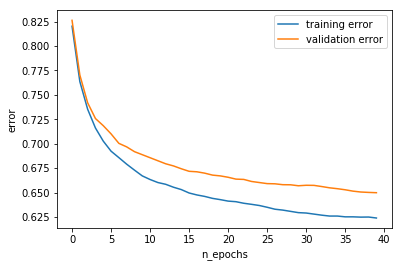

Execution time:  102.05052423477173
The accuracy on test set:  35.83 %


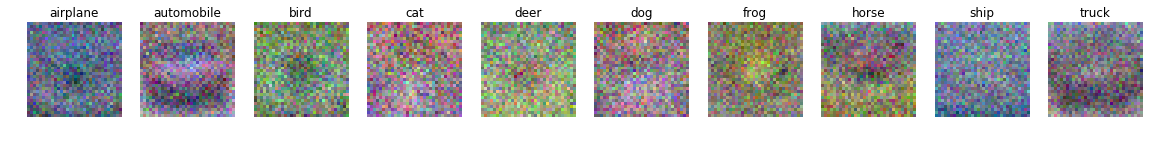

In [39]:
# Compare
lamb = 0.01
GDparams = Parameter(100,0.001,40)
# svm
name_par = 'svm-5'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-5'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

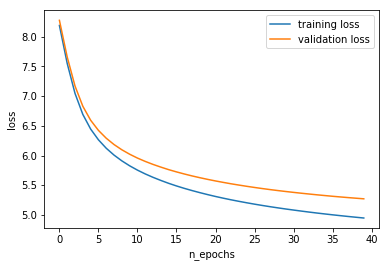

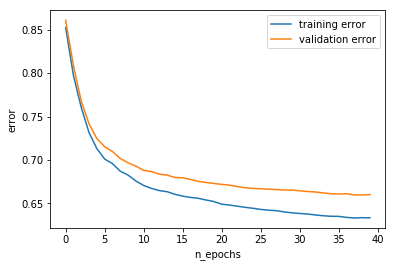

Execution time:  47.54252481460571
The accuracy on test set:  34.81 %


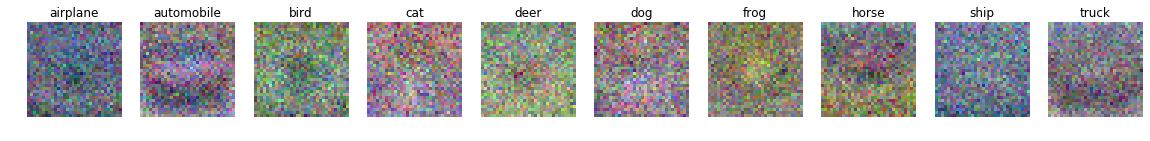

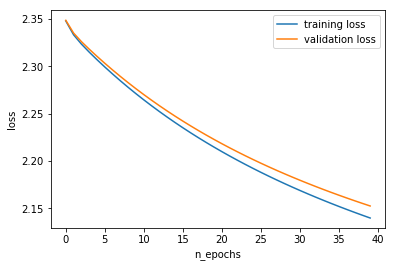

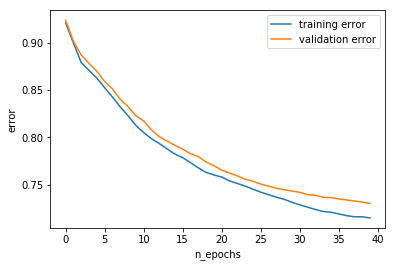

Execution time:  100.010568857193
The accuracy on test set:  27.83 %


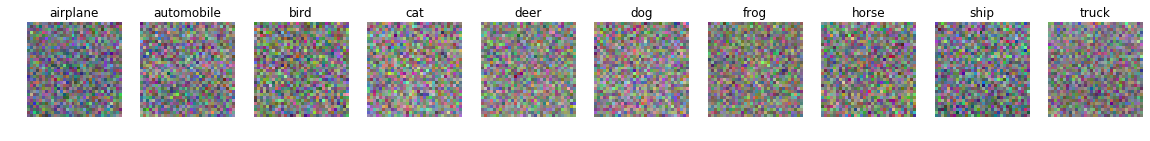

In [40]:
# Compare
lamb = 0.01
GDparams = Parameter(100,0.0001,40)
# svm
name_par = 'svm-6'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par,loss_func='svm')
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star,loss_func='svm')*100,'%')

plotW(W_star,class_name,name_par)

# smle
name_par = 'smle-6'

start = time.time()
W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,arg_par=name_par)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_star,b_star)*100,'%')

plotW(W_star,class_name,name_par)

In [7]:
# (h)
def ensembleTrain(X,Y,y,GDparams,lamb,eta_factor=1,name_par='h',shuf=False,plot=False,T=10):
    K = 10
    d = X[0].shape[0]
    W_star = np.zeros((K,d,T))
    b_star = np.zeros((K,T))
    acc = np.zeros(T)
    for i in range(T):
        W = np.random.randn(K,d) * 0.01
        b = np.random.randn(K,1) * 0.01
    
        W_star[:,:,i],b_star[:,[i]] = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,eta_factor,name_par,shuf,plot)
    return W_star,b_star

def predictValue(X,W,b):
    K,d,T = W.shape
    N = X.shape[1]
    y_pred = np.zeros((T,N))
    for i in range(T):
        P = evaluateClassifier(X,W_star[:,:,i],b_star[:,i].reshape(-1,1))
        y_pred[i,:] = np.argmax(P, axis=0)
    
    y_pred = y_pred.astype(int)
    
    y_major = np.zeros(N)   
    for j in range(N):
        y_major[j] = np.argmax(np.bincount(y_pred[:,j]))
    return y_major

def computeAccEnsem(X,y,W,b):
    y_pred = predictValue(X,W,b)
    acc = np.sum(y==y_pred)/(len(y)+0.0)
    return acc

In [13]:
# (c) A grid to find the good values for regularization, learning rate and batch size
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

d = XTr.shape[0]

W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01
lambdas = [0,0.01,0.1,0.5]
etas = [0.001,0.01,0.05]
n_batchs = [10,100,500]
accuracy = np.zeros((len(lambdas),len(etas),len(n_batchs)))

start = time.time()
for i,lamb in enumerate(lambdas):
    for j,eta in enumerate(etas):
        for k,n_batch in enumerate(n_batchs):
            GDparams = Parameter(n_batch,eta,20)
            W_star,b_star = miniBatchGD_improve(X,Y,y,GDparams,W,b,lamb,plot=False)
            accuracy[i,j,k] = computeAccuracy(XVa,yVa,W_star,b_star)
    print('Execution time: ',time.time()-start)

print(accuracy)

Execution time:  279.43797492980957
Execution time:  590.6520681381226
Execution time:  888.713536977768
Execution time:  888.7151210308075
[[[0.3693 0.3411 0.2813]
  [0.3302 0.3622 0.3548]]

 [[0.3451 0.3397 0.2832]
  [0.255  0.3338 0.352 ]]

 [[0.3019 0.3298 0.2832]
  [0.1878 0.2554 0.3304]]]


In [53]:
# Test ensemble
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

d = XTr.shape[0]

W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01
lamb = 0
GDparams = Parameter(100,0.01,40)
name_par = '0'

start = time.time()
W_star,b_star = ensembleTrain(X,Y,y,GDparams,lamb,T=20)
print('Execution time: ',time.time()-start)
print('The accuracy on training set: ',computeAccEnsem(XTr,yTr,W_star,b_star)*100,'%')
print('The accuracy on validation set: ',computeAccEnsem(XVa,yVa,W_star,b_star)*100,'%')
print('The accuracy on test set: ',computeAccEnsem(XTe,yTe,W_star,b_star)*100,'%')

Execution time:  799.8707339763641
The accuracy on training set:  41.48 %
The accuracy on validation set:  36.33 %
The accuracy on test set:  36.97 %


In [54]:
# Test ensemble
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

d = XTr.shape[0]

W = np.random.randn(K,d) * 0.01
b = np.random.randn(K,1) * 0.01
lamb = 0.1
GDparams = Parameter(10,0.01,10)
name_par = '0'

start = time.time()
W_star,b_star = ensembleTrain(X,Y,y,GDparams,lamb,shuf=True,T=20)
print('Execution time: ',time.time()-start)
print('The accuracy on training set: ',computeAccEnsem(XTr,yTr,W_star,b_star)*100,'%')
print('The accuracy on validation set: ',computeAccEnsem(XVa,yVa,W_star,b_star)*100,'%')
print('The accuracy on test set: ',computeAccEnsem(XTe,yTe,W_star,b_star)*100,'%')

Execution time:  357.91751503944397
The accuracy on training set:  35.19 %
The accuracy on validation set:  32.940000000000005 %
The accuracy on test set:  33.42 %


In [ ]:
# Using PCA to reduce the dimention of data
pcadim = 20
pca = decomposition.PCA(n_components=pcadim)
pca.fit(XTr.T)
XTr = pca.transform(XTr.T).T
XVa = pca.transform(XVa.T).T
XTe = pca.transform(XTe.T).T